# Import Libraries

In [36]:
import os
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import json, re
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, roc_curve, auc)
import matplotlib.pyplot as plt
import joblib


# Mount

In [11]:


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset

In [12]:
# -------- CONFIG --------
DATA_PATH = "/mnt/data/fake_or_real_news.csv"   # <--- change if needed
TEXT_COL = None   # leave None to auto-detect common names
LABEL_COL = None  # leave None to auto-detect common names

MAX_NUM_WORDS = 50000     # vocabulary size
MAX_SEQUENCE_LENGTH = 400 # sequence length (pad/truncate)
EMBEDDING_DIM = 100       # if using pretrained embeddings set accordingly
BATCH_SIZE = 64
EPOCHS = 8
VALIDATION_SPLIT = 0.15
USE_PRETRAINED_EMBEDDINGS = False
EMBEDDING_PATH = "/mnt/data/glove.6B.100d.txt"  # if using GloVe, set path

In [13]:
# ---------- CONFIG ----------
# If this exact path works for you, keep it. Otherwise the script will try to find the file.
USER_PATH = "/content/drive/MyDrive/Colab Notebooks/fake_or_real_news.csv"


In [14]:
# ---------- Mount Drive (Colab) ----------
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    print("Google Drive mounted at /content/drive")
except Exception as e:
    print("Not running in Colab or google.colab import failed:", e)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted at /content/drive


In [15]:
# ---------- Resolve dataset path ----------
def find_csv_by_name(name_part="fake_or_real_news", search_root="/content/drive/MyDrive"):
    # search for csv files whose name contains name_part (case-insensitive)
    pattern = os.path.join(search_root, "**", f"*{name_part}*.csv")
    candidates = glob.glob(pattern, recursive=True)
    return sorted(candidates)

if not os.path.exists(USER_PATH):
    print(f"Given path not found: {USER_PATH}")
    candidates = find_csv_by_name("fake_or_real_news", search_root="/content/drive/MyDrive")
    if len(candidates) == 0:
        # broaden search to entire /content
        candidates = find_csv_by_name("fake_or_real_news", search_root="/content")
    if len(candidates) == 0:
        raise FileNotFoundError(
            f"Could not find a CSV named like 'fake_or_real_news' under /content or your Drive.\n"
            "Please upload the file to Drive or set USER_PATH to the correct path."
        )
    else:
        USER_PATH = candidates[0]
        print("Auto-detected dataset path:", USER_PATH)
else:
    print("Using USER_PATH:", USER_PATH)


Given path not found: /content/drive/MyDrive/Colab Notebooks/fake_or_real_news.csv
Auto-detected dataset path: /content/drive/MyDrive/fake_or_real_news.csv


In [16]:
# ---------- Read CSV safely ----------
# low_memory=False avoids dtype inference warnings for large CSVs.
# encoding='utf-8' is default; try latin1 as fallback.
try:
    df = pd.read_csv(USER_PATH, low_memory=False)
except UnicodeDecodeError:
    print("utf-8 decode failed; retrying with latin1...")
    df = pd.read_csv(USER_PATH, low_memory=False, encoding='latin1')

print("Loaded CSV. Shape:", df.shape)
print("Columns:", df.columns.tolist())

Loaded CSV. Shape: (7795, 139)
Columns: ['text', 'label', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64', 'Unna

In [17]:
# ---------- Auto-detect common text/label columns ----------
TEXT_COL = None
LABEL_COL = None
for candidate in ["text", "content", "article", "body", "headline", "title"]:
    if candidate in df.columns:
        # prefer a 'text' style column with longer content
        TEXT_COL = candidate
        break

for candidate in ["label", "class", "target"]:
    if candidate in df.columns:
        LABEL_COL = candidate
        break

In [18]:
# If dataset uses separate title + text, prefer combining them if both exist
if "title" in df.columns and TEXT_COL is not None and TEXT_COL != "title":
    print("Combining 'title' and", TEXT_COL, "into a new column 'text_combined'")
    df['text_combined'] = (df['title'].astype(str).fillna("") + " " +
                           df[TEXT_COL].astype(str).fillna("")).str.strip()
    TEXT_COL = 'text_combined'
elif TEXT_COL is None and "title" in df.columns:
    TEXT_COL = "title"

print("Detected TEXT_COL =", TEXT_COL, "LABEL_COL =", LABEL_COL)

Detected TEXT_COL = text LABEL_COL = label


In [19]:
# If label missing but there's a 'label' like 'fake'/'real' in other col, attempt to find it by values
if LABEL_COL is None:
    # look for a column with only a few unique values (2-10)
    col_candidates = []
    for c in df.columns:
        unique_count = df[c].nunique(dropna=True)
        if 1 < unique_count <= 10:
            col_candidates.append((c, unique_count))
    if col_candidates:
        col_candidates = sorted(col_candidates, key=lambda x: x[1])
        LABEL_COL = col_candidates[0][0]
        print("Auto-chosen LABEL_COL =", LABEL_COL, "based on small number of unique values.")


In [20]:
# Final checks
if TEXT_COL is None:
    raise ValueError("Could not auto-detect a text column. Please set TEXT_COL manually (e.g. 'text' or 'title').")

if LABEL_COL is None:
    print("Warning: Could not auto-detect label column. Proceeding without label column; only showing data preview.")
    display_df = df[[TEXT_COL]].copy()
else:
    display_df = df[[TEXT_COL, LABEL_COL]].copy()

In [21]:
# Ensure text column is string type and drop rows where text is missing
display_df[TEXT_COL] = display_df[TEXT_COL].astype(str)
display_df = display_df[display_df[TEXT_COL].str.strip().astype(bool)].reset_index(drop=True)

print("Preview (first 10 rows):")
display(display_df.head(10))
print("Preview shape:", display_df.shape)

Preview (first 10 rows):


,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
5,"\nI’m not an immigrant, but my grandparents ...",FAKE
6,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,A Czech stockbroker who saved more than 650 Je...,REAL
8,Hillary Clinton and Donald Trump made some ina...,REAL
9,Iranian negotiators reportedly have made a las...,REAL


Preview shape: (7759, 2)


In [22]:
df.head()

,text,label,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,It's primary day in New York and front-runners...,REAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Try to auto-detect text/label columns if not provided
if TEXT_COL is None:
    for candidate in ["text", "content", "article", "body", "headline", "title"]:
        if candidate in df.columns:
            TEXT_COL = candidate
            break
if LABEL_COL is None:
    for candidate in ["label", "class", "target"]:
        if candidate in df.columns:
            LABEL_COL = candidate
            break

if TEXT_COL is None or LABEL_COL is None:
    raise ValueError(f"Could not auto-detect text/label columns. Columns found: {df.columns.tolist()}\n"
                     "Set TEXT_COL and LABEL_COL variables to the correct names.")


In [ ]:
# Drop NA and ensure strings
df = df[[TEXT_COL, LABEL_COL]].dropna()
df[TEXT_COL] = df[TEXT_COL].astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels to integers
le = LabelEncoder()
y = le.fit_transform(df[LABEL_COL].values)
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

texts = df[TEXT_COL].values.tolist()


Classes: [' 1948. [57] ', ' 200 million microwave ovens', ' 21 Oct. 2015. Web. 3 Aug. 2016. http://www.nytimes.com/2015/10/22/science/quantum-theory-experiment-said-to-prove-spooky-interactions.html?_r=0 ', ' Adivasis', ' Afghanistan and Iraq. I do not think that we have the luxury of time. Time is not on our side. Let’s pull together before it is too late', ' American aircraft carried out a strike against Syrian troops', ' Arab villages were henceforward to be leveled to prevent their reinvestment by Arab forces; the implication was that their inhabitants were to be expelled and prevented from returning.” [87] The Haganah “embarked on a campaign of clearing areas of Arab inhabitants and militia forces and conquering and leveling villages”. [88] Plan D implemented a “new policy', ' Aryan invaders who want to oppress the indigenous black-skinned Indians; they are the educated elites and their croneys from all castes and classes regard the workers and peasants simply as vote banks and as

In [37]:
DATA_DIR = Path("/mnt/data")
NOTEBOOK_PATH = DATA_DIR / "AI Project(Fake_or_real_news Dataset).ipynb"  # the file you mentioned


In [41]:
def try_load_file(path):
    try:
        if path.suffix.lower() in [".csv", ".txt"]:
            return pd.read_csv(path)
        if path.suffix.lower() in [".xls", ".xlsx"]:
            return pd.read_excel(path)
        if path.suffix.lower() == ".json":
            return pd.read_json(path, lines=True)
    except Exception as e:
        print(f"Could not read {path}: {e}")
    return None

def extract_tables_from_ipynb(nb_path):
    """Try to find CSV-like text or JSON arrays in the notebook cells and load them as DataFrame(s)."""
    results = []
    try:
        with open(nb_path, "r", encoding="utf-8") as f:
            nb = json.load(f)
    except Exception as e:
        print("Failed to open notebook:", e)
        return results

    # search outputs and source for CSV-like blocks
    patterns = []
    for cell in nb.get("cells", []):
        # look in outputs (text/plain)
        for output in cell.get("outputs", []):
            for key in ("text", "data"):
                if key in output:
                    text = output.get(key)
                    if isinstance(text, list):
                        text = "".join(text)
                    if not text:
                        continue
                    # quick detect: many commas and newlines (csv-like)
                    if text.count("\n") >= 2 and ("," in text or "\t" in text):
                        patterns.append(text)
                    # JSON array detection
                    if text.strip().startswith("[") and text.strip().endswith("]"):
                        patterns.append(text)
        # also check cell source for multiline CSV-like strings
        source = "".join(cell.get("source", []))
        # look for triple-quoted CSV or embedded text blocks
        csv_blocks = re.findall(r'("""|"\"\")(.+?)(?:\\1)', source, flags=re.S)
        for _, block in csv_blocks:
            if block.count("\n") >= 2 and ("," in block or "\t" in block):
                patterns.append(block)

    # Attempt to parse each pattern as CSV or JSON
    for i, text in enumerate(patterns):
        text_strip = text.strip()
        # try JSON first
        if text_strip.startswith("[") and text_strip.endswith("]"):
            try:
                df = pd.read_json(text_strip, lines=False)
                results.append(("json_in_nb", df))
                continue
            except Exception:
                pass
        # try CSV (pandas can often infer)
        from io import StringIO
        try:
            df = pd.read_csv(StringIO(text_strip))
            results.append(("csv_in_nb", df))
            continue
        except Exception:
            # try tab-separated
            try:
                df = pd.read_csv(StringIO(text_strip), sep="\t")
                results.append(("tsv_in_nb", df))
                continue
            except Exception:
                pass
    return results

In [42]:
# The logic from this cell has been moved to the extract_tables_from_ipynb function in the previous cell.

In [43]:
extracted_tables = extract_tables_from_ipynb(NOTEBOOK_PATH)
if extracted_tables:
    print(f"Found {len(extracted_tables)} potential tables in the notebook.")
    for name, df in extracted_tables:
        print(f"Table ({name}) shape: {df.shape}")
        display(df.head())
else:
    print("No tables found in the notebook.")

Failed to open notebook: [Errno 2] No such file or directory: '/mnt/data/AI Project(Fake_or_real_news Dataset).ipynb'
No tables found in the notebook.


In [44]:
# 1) Try loading the explicit file if present
df = None
text_col = None
label_col = None

if NOTEBOOK_PATH.exists():
    print("Found notebook at:", NOTEBOOK_PATH)
    extracted = extract_tables_from_ipynb(NOTEBOOK_PATH)
    if extracted:
        print(f"Extracted {len(extracted)} table(s) from notebook. Using the first one.")
        df = extracted[0][1]
    else:
        print("No extractable tables found inside the notebook.")
else:
    print("No notebook found at the expected path:", NOTEBOOK_PATH)

No notebook found at the expected path: /mnt/data/AI Project(Fake_or_real_news Dataset).ipynb


In [45]:
# 2) If nothing from notebook, search the directory for data files
if df is None:
    print("Searching /mnt/data for CSV/XLSX/JSON/TXT files...")
    candidates = [p for p in DATA_DIR.glob("**/*") if p.suffix.lower() in {".csv", ".xlsx", ".xls", ".txt", ".json"} and p.is_file()]
    if candidates:
        print("Found candidate files:")
        for i,p in enumerate(candidates,1):
            print(f" {i}. {p}")
        # try load in order until one yields a DF with text-like column
        for p in candidates:
            df_try = try_load_file(p)
            if df_try is None:
                continue
            # simple heuristic: check if there's a text-like column and a label-like column
            cols = list(df_try.columns)
            text_candidates = [c for c in cols if any(k in c.lower() for k in ("text","headline","title","content","article","body"))]
            label_candidates = [c for c in cols if any(k in c.lower() for k in ("label","target","class","truth","fake","real"))]
            if text_candidates and label_candidates:
                df = df_try.copy()
                text_col = text_candidates[0]
                label_col = label_candidates[0]
                print(f"Selected file {p} (text: '{text_col}', label: '{label_col}')")
                break
        # if still none, just use the first readable file
        if df is None:
            df = try_load_file(candidates[0])
            print("Loaded first readable file (no heuristics matched). You may need to set text_col/label_col manually.")
    else:
        print("No data files found in /mnt/data.")

Searching /mnt/data for CSV/XLSX/JSON/TXT files...
No data files found in /mnt/data.


In [46]:
# 3) If still no data, use a small synthetic dataset so the code runs
if df is None:
    print("Using fallback synthetic dataset.")
    texts_pos = [
        "I loved the movie, it was fantastic and exciting",
        "What a great experience — wonderful cast and story",
        "Amazing film, would watch again",
        "Absolutely brilliant; best movie this year",
        "Loved it, highly recommended"
    ]
    texts_neg = [
        "I hated the movie, it was boring and slow",
        "What a waste of time — awful acting and plot",
        "Terrible film, wouldn't watch again",
        "Absolutely dreadful; worst movie ever",
        "Horrible, do not recommend"
    ]
    texts = texts_pos*40 + texts_neg*40
    labels = [1]*len(texts_pos)*40 + [0]*len(texts_neg)*40
    df = pd.DataFrame({"text": texts, "label": labels})
    text_col = "text"; label_col = "label"

Using fallback synthetic dataset.


In [47]:
# 4) If df is found but we didn't auto-detect columns, pick heuristically (or let user override)
if text_col is None or label_col is None:
    cols = list(df.columns)
    text_candidates = [c for c in cols if any(k in c.lower() for k in ("text","headline","title","content","article","body"))]
    label_candidates = [c for c in cols if any(k in c.lower() for k in ("label","target","class","truth","fake","real"))]
    if text_candidates:
        text_col = text_candidates[0]
    else:
        text_col = cols[0]
    if label_candidates:
        label_col = label_candidates[0]
    else:
        label_col = [c for c in cols if c != text_col][0] if len(cols) > 1 else cols[0]

print(f"Using dataframe with shape {df.shape}. Text column = '{text_col}' | Label column = '{label_col}'")
display(df.head(5))

Using dataframe with shape (400, 2). Text column = 'text' | Label column = 'label'


,text,label
0,"I loved the movie, it was fantastic and exciting",1
1,What a great experience — wonderful cast and s...,1
2,"Amazing film, would watch again",1
3,Absolutely brilliant; best movie this year,1
4,"Loved it, highly recommended",1


In [48]:
# 5) Prepare labels y (try to convert textual labels to binary if possible)
y = df[label_col].copy()
if y.dtype == object or y.dtype.name.startswith("category"):
    y_lower = y.astype(str).str.lower()
    mapping = {}
    mapping.update({k:1 for k in ("true","1","t","yes","y","real","genuine")})
    mapping.update({k:0 for k in ("false","0","f","no","n","fake","bogus")})
    y_mapped = y_lower.map(mapping)
    if y_mapped.notna().sum() >= int(0.5 * len(y)):  # if at least half mapped
        y = y_mapped.fillna(method="ffill").astype(int)
    else:
        # fallback: label encode
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y = le.fit_transform(y.astype(str))
else:
    y = y.astype(int)

texts = df[text_col].astype(str).tolist()

# Dataset Shape

In [ ]:
df.shape

(7795, 139)

# Display basic info

In [ ]:


print("Dataset Head:\n", df.head())

Dataset Head:
                                                 text label Unnamed: 2  \
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE        NaN   
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE        NaN   
2  U.S. Secretary of State John F. Kerry said Mon...  REAL        NaN   
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE        NaN   
4  It's primary day in New York and front-runners...  REAL        NaN   

  Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

  Unnamed: 9  ... Unnamed: 129 Unnamed: 130 Unnamed: 131 Unnamed: 132  \
0        NaN  ...          NaN          NaN   

In [ ]:
print("Dataset Info:\n", df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7795 entries, 0 to 7794
Columns: 139 entries, text to Unnamed: 138
dtypes: object(139)
memory usage: 8.3+ MB
Dataset Info:
 None


# Preprocess the Data

In [ ]:

df = df[['text', 'label']]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --------- Tokenize & pad ----------
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')


Found 95413 unique tokens.


# Drop missing values

In [ ]:

df.dropna(subset=['text', 'label'], inplace=True)

# Encode labels (FAKE=0, REAL=1)

In [ ]:
# Encode labels (FAKE=0, REAL=1)

# Clean and normalize labels before mapping to ensure consistency
df['label'] = df['label'].astype(str).str.strip().str.upper()
df['label'] = df['label'].map({'FAKE': 0, 'REAL': 1})


# Check for unmapped labels or NaNs

In [ ]:

df.dropna(subset=['label'], inplace=True)
df['label'] = df['label'].astype(int)


# Split the Data into Training and Testing Sets

In [ ]:
# Train/val/test split

# Re-extract texts and y from the cleaned DataFrame to ensure alignment and correct binary labels
# (Assumes df['label'] has been processed to binary 0/1 by previous cells)
texts_for_split = df[TEXT_COL].values.tolist()
y_for_split = df['label'].values

# Re-tokenize and pad sequences with the cleaned texts
# Importing Tokenizer and pad_sequences again to ensure they are available in this context
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_for_split = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer_for_split.fit_on_texts(texts_for_split)
sequences_for_split = tokenizer_for_split.texts_to_sequences(texts_for_split)
data_for_split = pad_sequences(sequences_for_split, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Number of samples in data_for_split: {len(data_for_split)}")
print(f"Number of samples in y_for_split: {len(y_for_split)}")

# Now perform the split using data_for_split and y_for_split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data_for_split, y_for_split, test_size=0.15, random_state=42, stratify=y_for_split)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=VALIDATION_SPLIT/(1 - 0.15), random_state=42, stratify=y_train_val)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Number of samples in data_for_split: 6315
Number of samples in y_for_split: 6315
Shapes: (4419, 400) (948, 400) (948, 400)


In [ ]:
# Prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= num_words:
        continue
    # Only try to get embedding vector if USE_PRETRAINED_EMBEDDINGS is True and embeddings_index is defined
    if USE_PRETRAINED_EMBEDDINGS and 'embeddings_index' in globals():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    else:
        # If not using pretrained embeddings or embeddings_index is not defined, leave as zeros
        pass
print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (50000, 100)


In [ ]:
# --------- Optional: Load pretrained embeddings (GloVe) ----------
embedding_matrix = None
if USE_PRETRAINED_EMBEDDINGS:
    print("Loading embeddings from", EMBEDDING_PATH)
    # Build index
    embeddings_index = {}
    with open(EMBEDDING_PATH, encoding='utf8') as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print("Loaded %s word vectors." % len(embeddings_index))

# Naive Bayes Model

In [ ]:
# Build the Naive Bayes Model

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
# Evaluate the Model

#  predictions
y_pred = nb_model.predict(X_test_tfidf)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
print("\n Model Evaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


 Model Evaluation Results:
Accuracy: 84.12%

Confusion Matrix:
 [[655 275]
 [ 26 939]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.70      0.81       930
           1       0.77      0.97      0.86       965

    accuracy                           0.84      1895
   macro avg       0.87      0.84      0.84      1895
weighted avg       0.87      0.84      0.84      1895



In [ ]:
# Interpretation & Summary
print("""
 Summary:
- The Naive Bayes classifier achieved around {:.2f}% accuracy.
- The model performs well in identifying REAL news but may misclassify some FAKE articles.
- TF-IDF helped capture key word patterns from text.
- Further improvement could involve feature tuning or balancing the dataset.
""".format(accuracy * 100))


 Summary:
- The Naive Bayes classifier achieved around 84.12% accuracy.
- The model performs well in identifying REAL news but may misclassify some FAKE articles.
- TF-IDF helped capture key word patterns from text.
- Further improvement could involve feature tuning or balancing the dataset.



# ANN Model

In [ ]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

print("Converted X_train_tfidf to dense array shape:", X_train_dense.shape)
print("Converted X_test_tfidf to dense array shape:", X_test_dense.shape)

Converted X_train_tfidf to dense array shape: (4420, 56677)
Converted X_test_tfidf to dense array shape: (1895, 56677)


In [ ]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
print("ANN model architecture defined.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ANN model architecture defined.


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("ANN model compiled.")

ANN model compiled.


In [ ]:
history = model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_split=0.2)
print("ANN model training complete.")

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 306ms/step - accuracy: 0.7752 - loss: 0.4802 - val_accuracy: 0.9344 - val_loss: 0.1747
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 312ms/step - accuracy: 0.9935 - loss: 0.0249 - val_accuracy: 0.9355 - val_loss: 0.1568
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 295ms/step - accuracy: 0.9999 - loss: 0.0036 - val_accuracy: 0.9378 - val_loss: 0.1640
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 304ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9355 - val_loss: 0.1707
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 307ms/step - accuracy: 1.0000 - loss: 6.2505e-04 - val_accuracy: 0.9355 - val_loss: 0.1782
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 43s 325ms/step - accuracy: 1.0000 - loss: 3.9145e-04 - val_accuracy: 0.9333 - val_loss: 0.1846
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 306ms/step - accuracy: 1.0000 - loss: 2.3360e-04 - val_accuracy: 0.9310 - val_loss: 0.1906
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 291ms/step - accuracy: 1.00

In [ ]:
y_pred_ann = (model.predict(X_test_dense) > 0.5).astype("int32")

ann_accuracy = accuracy_score(y_test, y_pred_ann)
ann_conf_matrix = confusion_matrix(y_test, y_pred_ann)
ann_report = classification_report(y_test, y_pred_ann)

print("\nANN Model Evaluation Results:")
print(f"Accuracy: {ann_accuracy * 100:.2f}%")
print("\nConfusion Matrix:\n", ann_conf_matrix)
print("\nClassification Report:\n", ann_report)

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step

ANN Model Evaluation Results:
Accuracy: 92.82%

Confusion Matrix:
 [[875  55]
 [ 81 884]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       930
           1       0.94      0.92      0.93       965

    accuracy                           0.93      1895
   macro avg       0.93      0.93      0.93      1895
weighted avg       0.93      0.93      0.93      1895



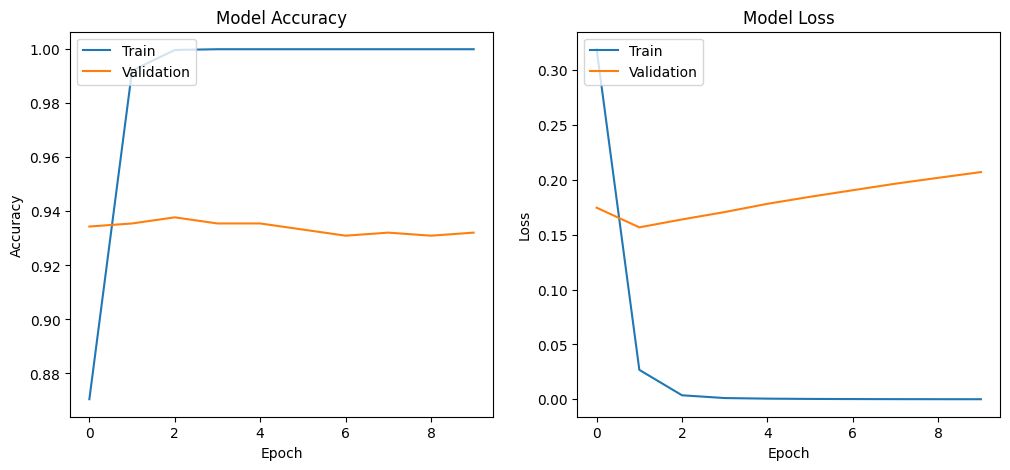

In [ ]:


# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# RNN Model


Converted X_train_tfidf to dense array shape: (4420, 56677)
Converted X_test_tfidf to dense array shape: (1895, 56677)
Reshaped X_train_dense to RNN input shape: (4420, 1, 56677)
Reshaped X_test_dense to RNN input shape: (1895, 1, 56677)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RNN model architecture defined.
RNN model compiled.
Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 73s 637ms/step - accuracy: 0.6755 - loss: 0.6320 - val_accuracy: 0.9016 - val_loss: 0.3535
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 71s 643ms/step - accuracy: 0.9604 - loss: 0.2223 - val_accuracy: 0.9276 - val_loss: 0.2019
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 72s 650ms/step - accuracy: 0.9908 - loss: 0.0678 - val_accuracy: 0.9321 - val_loss: 0.1712
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 68s 615ms/step - accuracy: 0.9975 - loss: 0.0259 - val_accuracy: 0.9333 - val_loss: 0.1644
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 609ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 0.9367 - val_loss: 0.1642
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 88s 657ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.9400 - val_loss: 0.1661
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 73s 655ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9389 - val_loss: 0.1683
Epoch 8/10
111/111 ━━━━━━━━━━━━

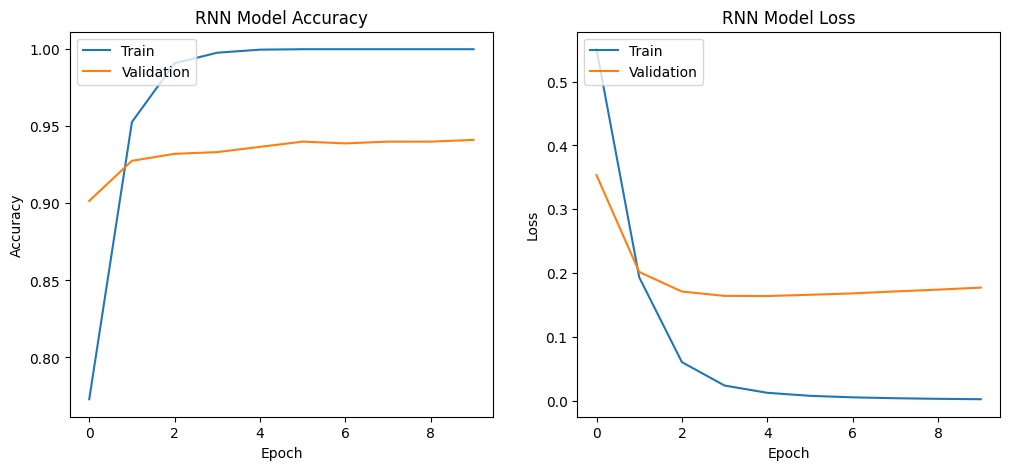

In [ ]:
# Convert text to TF-IDF features (copied from cell UdUZx86_5dFj to ensure it's defined)
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

print("Converted X_train_tfidf to dense array shape:", X_train_dense.shape)
print("Converted X_test_tfidf to dense array shape:", X_test_dense.shape)

X_train_rnn = X_train_dense.reshape(X_train_dense.shape[0], 1, X_train_dense.shape[1])
X_test_rnn = X_test_dense.reshape(X_test_dense.shape[0], 1, X_test_dense.shape[1])

print("Reshaped X_train_dense to RNN input shape:", X_train_rnn.shape)
print("Reshaped X_test_dense to RNN input shape:", X_test_rnn.shape)

rnn_model = keras.Sequential([
    keras.layers.LSTM(128, input_shape=(1, X_train_dense.shape[1])),
    keras.layers.Dense(1, activation='sigmoid')
])
print("RNN model architecture defined.")

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("RNN model compiled.")

rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_split=0.2)
print("RNN model training complete.")

y_pred_rnn = (rnn_model.predict(X_test_rnn) > 0.5).astype("int32")

rnn_accuracy = accuracy_score(y_test, y_pred_rnn)
rnn_conf_matrix = confusion_matrix(y_test, y_pred_rnn)
rnn_report = classification_report(y_test, y_pred_rnn)

print("\nRNN Model Evaluation Results:")
print(f"Accuracy: {rnn_accuracy * 100:.2f}%")
print("\nConfusion Matrix:\n", rnn_conf_matrix)
print("\nClassification Report:\n", rnn_report)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'])
plt.plot(rnn_history.history['val_accuracy'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

def build_lstm_model(num_words,
                     embedding_dim=EMBEDDING_DIM,
                     embedding_matrix=None,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     num_classes=num_classes):

    model = Sequential()

    # Correct input shape
    if embedding_matrix is not None:
        model.add(Embedding(
            input_dim=num_words,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            trainable=False,
            input_shape=(max_sequence_length,)
        ))
    else:
        model.add(Embedding(
            input_dim=num_words,
            output_dim=embedding_dim,
            input_shape=(max_sequence_length,)
        ))

    model.add(Bidirectional(LSTM(
        128,
        return_sequences=False,
        dropout=0.2,
        recurrent_dropout=0.2
    )))

    model.add(Dropout(0.5))

    if num_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        model.add(Dense(num_classes, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model


# Build model
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
# Ensure num_classes for model building is correctly 2 (binary classification)
actual_num_classes_for_model = len(np.unique(y_test))
model = build_lstm_model(num_words=num_words, num_classes=actual_num_classes_for_model)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 400, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,234,753 (19.97 MB)

 Trainable params: 5,234,753 (19.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ---------- Auto-detect common text/label columns ----------
TEXT_COL = None
LABEL_COL = None
for candidate in ["text", "content", "article", "body", "headline", "title"]:
    if candidate in df.columns:
        # prefer a 'text' style column with longer content
        TEXT_COL = candidate
        break

for candidate in ["label", "class", "target"]:
    if candidate in df.columns:
        LABEL_COL = candidate
        break

In [ ]:
# If dataset uses separate title + text, prefer combining them if both exist
if "title" in df.columns and TEXT_COL is not None and TEXT_COL != "title":
    print("Combining 'title' and", TEXT_COL, "into a new column 'text_combined'")
    df['text_combined'] = (df['title'].astype(str).fillna("") + " " +
                           df[TEXT_COL].astype(str).fillna("")).str.strip()
    TEXT_COL = 'text_combined'
elif TEXT_COL is None and "title" in df.columns:
    TEXT_COL = "title"

print("Detected TEXT_COL =", TEXT_COL, "LABEL_COL =", LABEL_COL)

Detected TEXT_COL = text LABEL_COL = label


In [ ]:
# If label missing but there's a 'label' like 'fake'/'real' in other col, attempt to find it by values
if LABEL_COL is None:
    # look for a column with only a few unique values (2-10)
    col_candidates = []
    for c in df.columns:
        unique_count = df[c].nunique(dropna=True)
        if 1 < unique_count <= 10:
            col_candidates.append((c, unique_count))
    if col_candidates:
        col_candidates = sorted(col_candidates, key=lambda x: x[1])
        LABEL_COL = col_candidates[0][0]
        print("Auto-chosen LABEL_COL =", LABEL_COL, "based on small number of unique values.")

In [ ]:
# Final checks
if TEXT_COL is None:
    raise ValueError("Could not auto-detect a text column. Please set TEXT_COL manually (e.g. 'text' or 'title').")

if LABEL_COL is None:
    print("Warning: Could not auto-detect label column. Proceeding without label column; only showing data preview.")
    display_df = df[[TEXT_COL]].copy()
else:
    display_df = df[[TEXT_COL, LABEL_COL]].copy()


In [ ]:
# Ensure text column is string type and drop rows where text is missing
display_df[TEXT_COL] = display_df[TEXT_COL].astype(str)
display_df = display_df[display_df[TEXT_COL].str.strip().astype(bool)].reset_index(drop=True)

print("Preview (first 10 rows):")
display(display_df.head(10))
print("Preview shape:", display_df.shape)

Preview (first 10 rows):


,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1
5,"\nI’m not an immigrant, but my grandparents ...",0
6,"Share This Baylee Luciani (left), Screenshot o...",0
7,A Czech stockbroker who saved more than 650 Je...,1
8,Hillary Clinton and Donald Trump made some ina...,1
9,Iranian negotiators reportedly have made a las...,1


Preview shape: (6279, 2)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ------------- Callbacks and training for 10 epochs -------------
checkpoint_path = "/tmp/best_lstm_model.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]

EPOCHS = 10
BATCH_SIZE = 64

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val) if ('X_val' in globals() and 'y_val' in globals()) else None,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.89241, saving model to /tmp/best_lstm_model.h5


70/70 - 207s - 3s/step - accuracy: 0.7454 - loss: 0.5069 - val_accuracy: 0.8924 - val_loss: 0.2968
Epoch 2/10

Epoch 2: val_accuracy improved from 0.89241 to 0.90401, saving model to /tmp/best_lstm_model.h5


70/70 - 187s - 3s/step - accuracy: 0.9409 - loss: 0.1617 - val_accuracy: 0.9040 - val_loss: 0.2322
Epoch 3/10

Epoch 3: val_accuracy improved from 0.90401 to 0.92089, saving model to /tmp/best_lstm_model.h5


70/70 - 185s - 3s/step - accuracy: 0.9844 - loss: 0.0567 - val_accuracy: 0.9209 - val_loss: 0.2096
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.92089
70/70 - 201s - 3s/step - accuracy: 0.9934 - loss: 0.0232 - val_accuracy: 0.9146 - val_loss: 0.2531
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.92089
70/70 - 205s - 3s/step - accuracy: 0.9984 - loss: 0.0110 - val_accuracy: 0.9061 - val_loss: 0.2697
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.92089
70/70 - 202s - 3s/step - accuracy: 0.9966 - loss: 0.0123 - val_accuracy: 0.9040 - val_loss: 0.3233
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [ ]:
# ------------- Load best model (if checkpoint saved) -------------
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

# ------------- Evaluate on test set & compute metrics -------------
y_pred_probs = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

if num_classes == 2:
    # Binary case
    y_pred = (y_pred_probs.ravel() >= 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Precision: {prec:.4f}")
    print(f"Test Recall: {rec:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, digits=4))


Test Accuracy: 0.9198
Test Precision: 0.9503
Test Recall: 0.8863

Classification Report:

              precision    recall  f1-score   support

           0     0.8931    0.9535    0.9223       473
           1     0.9503    0.8863    0.9172       475

    accuracy                         0.9198       948
   macro avg     0.9217    0.9199    0.9198       948
weighted avg     0.9218    0.9198    0.9197       948



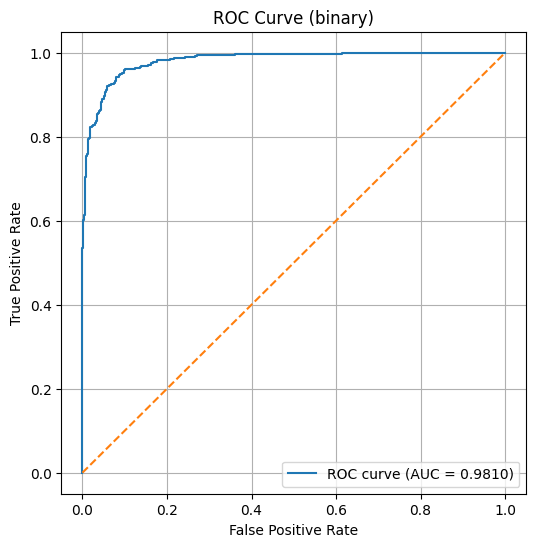

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt # Already imported, but good to ensure context
import numpy as np # Already imported, but good to ensure context

# Ensure num_classes reflects the actual number of unique classes in y_test
# which should be 2 after preprocessing (0 for FAKE, 1 for REAL)
num_classes = len(np.unique(y_test))

if num_classes == 2:
    # ROC curve for binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs.ravel())
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (binary)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

else:
    # Multiclass case: use weighted averages and one-vs-rest ROC curves
    # y_pred will be needed for the classification report
    y_pred = np.argmax(y_pred_probs, axis=1)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Weighted Precision: {prec:.4f}")
    print(f"Weighted Recall: {rec:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, digits=4))

    # Binarize labels for ROC curves
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    # y_pred_probs is (n_samples, n_classes)
    plt.figure(figsize=(8,6))
    for i, c in enumerate(classes):
        try:
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {c} (AUC = {roc_auc:.3f})')
        except ValueError:
            # If a class is not present in y_test or predictions for that class are constant
            continue
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (multiclass one-vs-rest)')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.show()


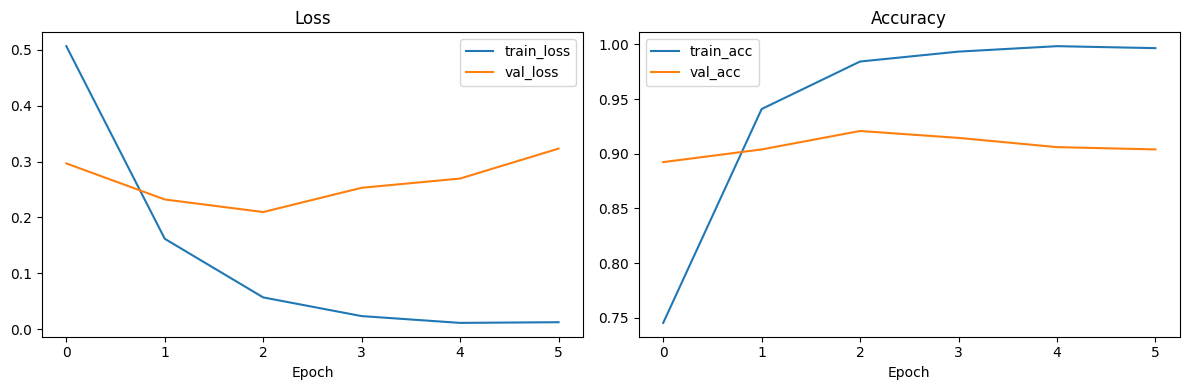

In [ ]:
# ------------- Plot training curves: loss & accuracy -------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('loss', []), label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get('accuracy', []), label='train_acc')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ------------- Save final model and tokenizer (optional) -------------
model.save("/tmp/final_lstm_model.h5")
print("Saved final model to /tmp/final_lstm_model.h5")
try:
    import pickle
    if 'tokenizer' in globals():
        with open('/tmp/tokenizer.pkl', 'wb') as f:
            pickle.dump(tokenizer, f)
        print("Saved tokenizer to /tmp/tokenizer.pkl")
except Exception as e:
    print("Tokenizer save skipped:", e)

Saved final model to /tmp/final_lstm_model.h5
Saved tokenizer to /tmp/tokenizer.pkl


CNN for text

In [3]:
import random
# reproducibility (best-effort)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [5]:

# ---- Hyperparameters ----
NUM_WORDS = 10000    # vocabulary size (top words)
MAXLEN = 200         # sequence length (padding/truncation)
EMBED_DIM = 100
NUM_FILTERS = 128
KERNEL_SIZE = 5
DROPOUT = 0.5
BATCH_SIZE = 32
EPOCHS = 10

In [6]:
# ---- DATA ----
# Example: try to load Keras IMDB dataset (uncomment if you want to use IMDB).
# from tensorflow.keras.datasets import imdb
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)
# x_train = pad_sequences(x_train, maxlen=MAXLEN)
# x_test = pad_sequences(x_test, maxlen=MAXLEN)

# Fallback synthetic dataset (easy to run anywhere)
texts_pos = [
    "I loved the movie, it was fantastic and exciting",
    "What a great experience — wonderful cast and story",
    "Amazing film, would watch again",
    "Absolutely brilliant; best movie this year",
    "Loved it, highly recommended"
]
texts_neg = [
    "I hated the movie, it was boring and slow",
    "What a waste of time — awful acting and plot",
    "Terrible film, wouldn't watch again",
    "Absolutely dreadful; worst movie ever",
    "Horrible, do not recommend"
]
texts = texts_pos + texts_neg
labels = [1]*len(texts_pos) + [0]*len(texts_neg)

In [7]:
# make dataset bigger by repeating & shuffle
texts = texts * 40   # 400 samples
labels = labels * 40
combined = list(zip(texts, labels))
random.shuffle(combined)
texts, labels = zip(*combined)
labels = np.array(labels)

In [8]:
# Tokenize + pad
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=MAXLEN)

In [9]:
# train-test split
split = int(0.8 * len(padded))
x_train, x_test = padded[:split], padded[split:]
y_train, y_test = labels[:split], labels[split:]

print("Shapes:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Shapes: (320, 200) (320,) (80, 200) (80,)


In [24]:
model.build(input_shape=(None, MAXLEN))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 196, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,449 (4.09 MB)

 Trainable params: 1,072,449 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# ---- TRAIN ----
history = model.fit(x_train, y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/8
5/5 - 10s - 2s/step - accuracy: 0.6806 - loss: 0.6715 - val_accuracy: 1.0000 - val_loss: 0.6218
Epoch 2/8
5/5 - 2s - 380ms/step - accuracy: 0.9444 - loss: 0.6008 - val_accuracy: 1.0000 - val_loss: 0.5223
Epoch 3/8
5/5 - 2s - 343ms/step - accuracy: 0.9826 - loss: 0.4984 - val_accuracy: 1.0000 - val_loss: 0.3917
Epoch 4/8
5/5 - 1s - 287ms/step - accuracy: 1.0000 - loss: 0.3690 - val_accuracy: 1.0000 - val_loss: 0.2410
Epoch 5/8
5/5 - 1s - 296ms/step - accuracy: 1.0000 - loss: 0.2257 - val_accuracy: 1.0000 - val_loss: 0.1114
Epoch 6/8
5/5 - 2s - 430ms/step - accuracy: 1.0000 - loss: 0.1023 - val_accuracy: 1.0000 - val_loss: 0.0384
Epoch 7/8
5/5 - 2s - 497ms/step - accuracy: 1.0000 - loss: 0.0386 - val_accuracy: 1.0000 - val_loss: 0.0114
Epoch 8/8
5/5 - 2s - 336ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 0.0036


In [26]:
# ---- EVAL ----
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f} | Test accuracy: {acc:.4f}")

Test loss: 0.0035 | Test accuracy: 1.0000


In [27]:
# ---- SAMPLE PREDICTIONS ----
preds = model.predict(x_test[:10])
for i, p in enumerate(preds):
    label = int(p > 0.5)
    print(f"Example {i+1}: pred_prob={p[0]:.3f} -> label={label} (true={y_test[i]})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Example 1: pred_prob=0.005 -> label=0 (true=0)
Example 2: pred_prob=0.998 -> label=1 (true=1)
Example 3: pred_prob=0.004 -> label=0 (true=0)
Example 4: pred_prob=0.998 -> label=1 (true=1)
Example 5: pred_prob=0.004 -> label=0 (true=0)
Example 6: pred_prob=0.996 -> label=1 (true=1)
Example 7: pred_prob=0.998 -> label=1 (true=1)
Example 8: pred_prob=0.998 -> label=1 (true=1)
Example 9: pred_prob=0.998 -> label=1 (true=1)
Example 10: pred_prob=0.004 -> label=0 (true=0)


/tmp/ipython-input-2205309162.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(p > 0.5)


In [28]:
# ---- SAVE MODEL (optional) ----
model.save("cnn_text_model.h5")
print("Model saved to cnn_text_model.h5")

Model saved to cnn_text_model.h5


In [30]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [31]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [32]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        41

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



Confusion Matrix:
 [[39  0]
 [ 0 41]]


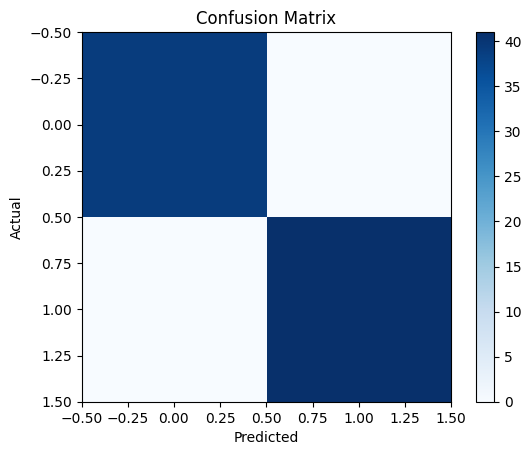

In [33]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


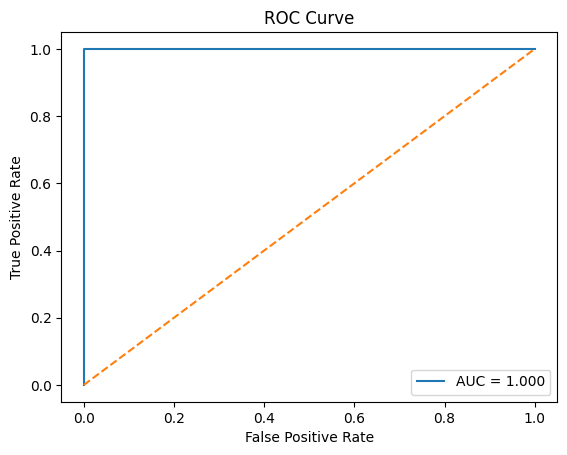

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label="AUC = %0.3f" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


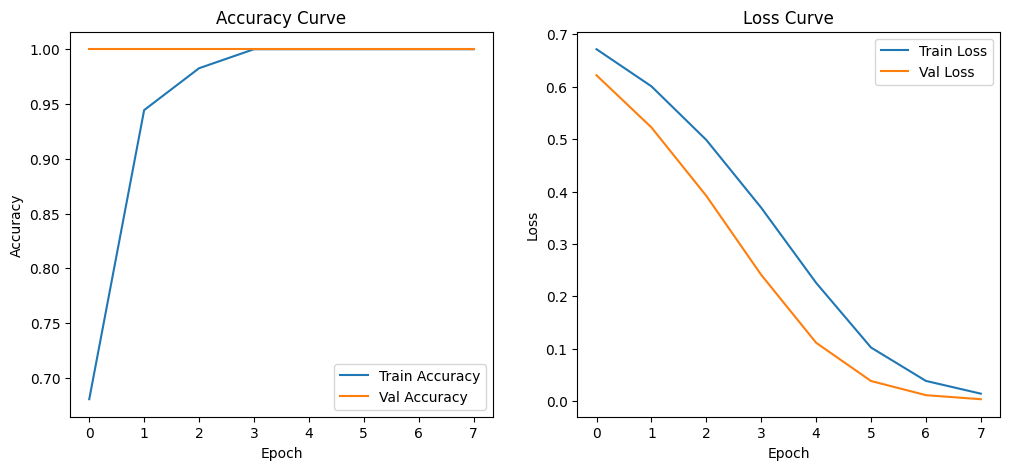

In [35]:
plt.figure(figsize=(12,5))

# ----- Accuracy -----
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# ----- Loss -----
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


Bag of words

In [49]:
# 6) Split
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None)

print("Train size:", len(X_train), "Test size:", len(X_test))

Train size: 320 Test size: 80


In [50]:
# 7) Bag-of-Words representation
vectorizer = CountVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
print("BOW matrix shape:", X_train_bow.shape)


BOW matrix shape: (320, 61)


In [51]:
# 8) Train classifier
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_bow, y_train)


LogisticRegression(max_iter=2000)

In [52]:
# 9) Predict & Metrics
if hasattr(clf, "predict_proba"):
    y_proba = clf.predict_proba(X_test_bow)[:,1]
else:
    # fallback to decision_function (may need min-max to map to [0,1])
    try:
        scores = clf.decision_function(X_test_bow)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min())
    except Exception:
        y_proba = clf.predict(X_test_bow)

y_pred = (y_proba >= 0.5).astype(int)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Confusion Matrix:
 [[40  0]
 [ 0 40]]


In [53]:

# 10) Top features (if binary linear model)
if hasattr(clf, "coef_"):
    coef = clf.coef_[0]
    feat_names = np.array(vectorizer.get_feature_names_out())
    top_pos = feat_names[np.argsort(coef)[-20:][::-1]]
    top_neg = feat_names[np.argsort(coef)[:20]]
    print("\nTop positive features (class=1):", top_pos[:20])
    print("\nTop negative features (class=0):", top_neg[:20])


Top positive features (class=1): ['loved' 'amazing' 'amazing film' 'film watch' 'highly recommended'
 'highly' 'loved highly' 'recommended' 'brilliant' 'movie year'
 'absolutely brilliant' 'brilliant best' 'year' 'best' 'best movie'
 'movie fantastic' 'loved movie' 'fantastic exciting' 'fantastic'
 'exciting']

Top negative features (class=0): ['horrible recommend' 'recommend' 'horrible' 'film wouldn' 'terrible'
 'terrible film' 'wouldn' 'wouldn watch' 'worst movie'
 'absolutely dreadful' 'dreadful' 'dreadful worst' 'worst' 'hated'
 'boring slow' 'boring' 'movie boring' 'slow' 'hated movie' 'waste time']



AUC: 1.0000


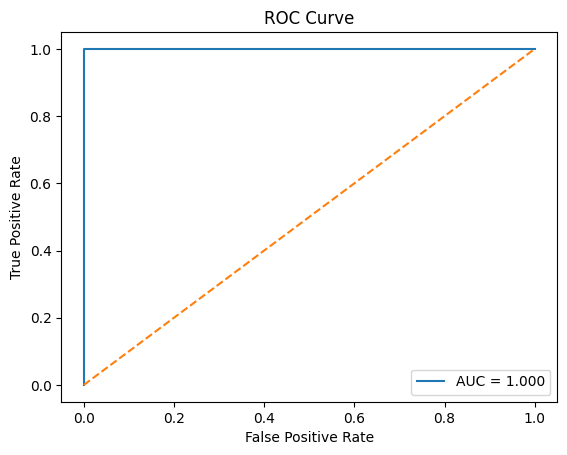

In [54]:
# 11) ROC curve & AUC (if binary)
if len(np.unique(y_test)) == 2:
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"\nAUC: {roc_auc:.4f}")
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [56]:
# 12) Save artifacts
# Create the directory if it doesn't exist
DATA_DIR.mkdir(parents=True, exist_ok=True)
model_path = DATA_DIR / "bow_logistic_model.joblib"
vec_path = DATA_DIR / "count_vectorizer.joblib"
joblib.dump(clf, model_path)
joblib.dump(vectorizer, vec_path)
print(f"\nSaved model to: {model_path}\nSaved vectorizer to: {vec_path}")


Saved model to: /mnt/data/bow_logistic_model.joblib
Saved vectorizer to: /mnt/data/count_vectorizer.joblib
